## Explore YOLO output + triangulation

In [28]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import json
import shutil
import sys
from pathlib import Path
from tqdm import tqdm

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

In [29]:
detections = pd.read_csv(f"{root}/data/stereo_detections.csv")

In [30]:
detections.head()

,frame_no,A1_x,A1_y,A1_confidence,A1_method,A2_x,A2_y,A2_confidence,A2_method
0,934,1803,407,0.813748,YOLO,210,422,0.834425,YOLO
1,935,1749,415,0.813780,YOLO,255,428,0.818114,YOLO
2,936,1698,422,0.830572,YOLO,297,435,0.594926,YOLO
3,937,1648,432,0.856475,YOLO,297,435,0.400000,LK
4,938,1647,431,0.400000,LK,297,435,0.300000,LK


In [31]:
detection = detections.iloc[0]
detection.to_dict()

{'frame_no': 934,
 'A1_x': 1803,
 'A1_y': 407,
 'A1_confidence': 0.8137478828430176,
 'A1_method': 'YOLO',
 'A2_x': 210,
 'A2_y': 422,
 'A2_confidence': 0.834425151348114,
 'A2_method': 'YOLO'}

In [39]:

def load_stereo_a_maps():
    file_path = f"{root}/output/STEREO_A_rectification_params.xml"
    cv_file = cv2.FileStorage(file_path, cv2.FILE_STORAGE_READ)

    stereo_maps = {
        "CAM_1_map_x": cv_file.getNode("CAM_1_map_x").mat(),
        "CAM_1_map_y": cv_file.getNode("CAM_1_map_y").mat(),
        "CAM_2_map_x": cv_file.getNode("CAM_2_map_x").mat(),
        "CAM_2_map_y": cv_file.getNode("CAM_2_map_y").mat(),
        "CAM_1_projection_matrix": cv_file.getNode("CAM_1_projection_matrix").mat(),
        "CAM_2_projection_matrix": cv_file.getNode("CAM_2_projection_matrix").mat(),
        "disparity_to_depth_matrix": cv_file.getNode("disparity_to_depth_matrix").mat(),
        "CAM_1_roi": cv_file.getNode("CAM_1_roi").mat(),
        "CAM_2_roi": cv_file.getNode("CAM_2_roi").mat(),
    }

    cv_file.release()
    return stereo_maps

def load_stereo_b_maps():
    file_path = f"{root}/output/STEREO_B_rectification_params_2.xml"
    cv_file = cv2.FileStorage(file_path, cv2.FILE_STORAGE_READ)

    stereo_maps = {
        "CAM_3_map_x": cv_file.getNode("CAM_3_map_x").mat(),
        "CAM_3_map_y": cv_file.getNode("CAM_3_map_y").mat(),
        "CAM_4_map_x": cv_file.getNode("CAM_4_map_x").mat(),
        "CAM_4_map_y": cv_file.getNode("CAM_4_map_y").mat(),
        "CAM_3_projection_matrix": cv_file.getNode("CAM_3_projection_matrix").mat(),
        "CAM_4_projection_matrix": cv_file.getNode("CAM_4_projection_matrix").mat(),
        "disparity_to_depth_matrix": cv_file.getNode("disparity_to_depth_matrix").mat(),
        "CAM_3_roi": cv_file.getNode("CAM_3_roi").mat(),
        "CAM_4_roi": cv_file.getNode("CAM_4_roi").mat(),
    }

    cv_file.release()
    return stereo_maps

In [40]:
# load intrinsics and extrinsics

with open(f"{root}/output/intrinsic_params.json", "r") as f:
    intrinsic_params = json.load(f)
    
with open(f"{root}/output/1_stereo_params.json", "r") as f:
    stereo_params = json.load(f)
    
# necessary parameters
K_cam1_undistort = np.array(intrinsic_params['CAM_1']['K_undistort'])
D_cam1_undistort = np.array(intrinsic_params['CAM_1']['D'])

K_cam2_undistort = np.array(intrinsic_params['CAM_2']['K_undistort'])
D_cam2_undistort = np.array(intrinsic_params['CAM_2']['D'])

stereo_maps = load_stereo_a_maps()
x_map_cam1 = stereo_maps['CAM_1_map_x']
y_map_cam1 = stereo_maps['CAM_1_map_y']

print(f"Map shapes: {x_map_cam1.shape}, {y_map_cam1.shape}")


P_cam1 = np.array(stereo_maps['CAM_1_projection_matrix'])
P_cam2 = np.array(stereo_maps['CAM_2_projection_matrix'])

x_map_cam2 = stereo_maps['CAM_2_map_x']
y_map_cam2 = stereo_maps['CAM_2_map_y']

print(f"Map shapes: {x_map_cam2.shape}, {y_map_cam2.shape}")

stereo_maps_b = load_stereo_b_maps()
x_map_cam3 = stereo_maps_b['CAM_3_map_x']
y_map_cam3 = stereo_maps_b['CAM_3_map_y']

print(f"Map shapes: {x_map_cam3.shape}, {y_map_cam3.shape}")

x_map_cam4 = stereo_maps_b['CAM_4_map_x']
y_map_cam4 = stereo_maps_b['CAM_4_map_y']

print(f"Map shapes: {x_map_cam4.shape}, {y_map_cam4.shape}")



Map shapes: (2160, 3840), (2160, 3840)
Map shapes: (2160, 3840), (2160, 3840)
Map shapes: (2160, 3840), (2160, 3840)
Map shapes: (2160, 3840), (2160, 3840)


In [34]:
detection = detection.to_dict()
detection

{'frame_no': 934,
 'A1_x': 1803,
 'A1_y': 407,
 'A1_confidence': 0.8137478828430176,
 'A1_method': 'YOLO',
 'A2_x': 210,
 'A2_y': 422,
 'A2_confidence': 0.834425151348114,
 'A2_method': 'YOLO'}

In [35]:
# TODO: get 2D coordinates from YOLO output
# NOTE: measure = pixels
scale_factor = 2 
cam1_2d = (detection['A1_x'] * scale_factor, detection['A1_y'] * scale_factor)
cam2_2d = (detection['A2_x'] * scale_factor, detection['A2_y'] * scale_factor)

# TODO: undirtort the points
# P to normalize the points into pixel coordinates
undistorted_point_camera_1 = cv2.undistortPoints(cam1_2d, K_cam1_undistort, D_cam1_undistort, P=K_cam1_undistort)
undistorted_point_camera_2 = cv2.undistortPoints(cam2_2d, K_cam2_undistort, D_cam2_undistort, P=K_cam2_undistort)
print(f"cam 1 undistorted: {undistorted_point_camera_1}")
print(f"cam 2 undistorted: {undistorted_point_camera_2}")

# TODO: projection matrix
P1 = np.dot(K_cam1_undistort, np.hstack((np.eye(3), np.zeros((3, 1)))))  # Camera 1's projection matrix
R2 = np.array(stereo_params['STEREO_A']['rotation_matrix'])  # Rotation matrix from stereo extrinsics
T2 = np.array(stereo_params['STEREO_A']['translation_vector'])  # Translation vector from stereo extrinsics
P2 = np.dot(K_cam2_undistort, np.hstack((R2, T2)))  # Camera 2's projection matrix

# TODO: triangulate
points_3d_homogeneous = cv2.triangulatePoints(P1, P2, undistorted_point_camera_1, undistorted_point_camera_2)

# TODO: convert to 3D points
points_3d = points_3d_homogeneous[:3] / points_3d_homogeneous[3]
print(f"points 3d: {points_3d}")
points_3d_meters = points_3d / 1000.0
print(f"points 3d meters: {points_3d_meters}")

cam 1 undistorted: [[[3554.85302176  831.92979699]]]
cam 2 undistorted: [[[398.58275221 851.09708965]]]
points 3d: [[3748.34950574]
 [-489.86007363]
 [4286.8599816 ]]
points 3d meters: [[ 3.74834951]
 [-0.48986007]
 [ 4.28685998]]


In [36]:
threshold = 15  # threshold in pixels

# Reproject 3D points (in mm) back to 2D
reprojected_point_1 = np.dot(P1, np.vstack((points_3d, np.ones((1, points_3d.shape[1])))))
reprojected_point_2 = np.dot(P2, np.vstack((points_3d, np.ones((1, points_3d.shape[1])))))

reprojected_point_1 /= reprojected_point_1[2]
reprojected_point_2 /= reprojected_point_2[2]

# NOTE: ravel() method is used to convert the 2D array into a 1D array
print(f"reprojected point 1: {reprojected_point_1[:2].ravel()}")
print(f"reprojected point 2: {reprojected_point_2[:2].ravel()}")

error1 = np.linalg.norm(reprojected_point_1[:2].ravel() - undistorted_point_camera_1.ravel())
error2 = np.linalg.norm(reprojected_point_2[:2].ravel() - undistorted_point_camera_2.ravel())
print(f"error 1: {error1}")
print(f"error 2: {error2}")

# TODO: formula for error in meters
cam1_fx = intrinsic_params['CAM_1']['fx']
cam2_fx = intrinsic_params['CAM_2']['fx']

Z = points_3d[2][0]  # depth in mm

error1_m = (error1 * Z) / (cam1_fx * 10) 
error2_m = (error2 * Z) / (cam2_fx * 10) 

print(f"error 1 (cm): {error1_m}")
print(f"error 2 (cm): {error2_m}")

if error1 > threshold or error2 > threshold:
    print("Anomaly detected!")

reprojected point 1: [3551.61886594  822.31092233]
reprojected point 2: [396.07100136 858.99408491]
error 1: 10.14803003875915
error 2: 8.28682245893773
error 1 (cm): 2.6479378462650676
error 2 (cm): 2.2297123378325963


In [37]:
import matplotlib.pyplot as plt

# TODO: using the reprojected points, plot the ball in the original frame 
frame_no = detection['frame_no']
frame_folder = f"{root}/images/annotated_frames/frame_{frame_no}"
cam1_frame = f"{frame_folder}/cam1.png"
cam2_frame = f"{frame_folder}/cam2.png"

# TODO: read the frames
cam1_frame = cv2.imread(cam1_frame)
cam2_frame = cv2.imread(cam2_frame)

# Plot reprojected points on original frames
def plot_reprojected_point(frame, point, color=(0, 0, 255), radius=20):
    """Plot a single point on frame. point = (x,y), color in BGR"""
    frame_copy = frame.copy()
    cv2.circle(frame_copy, (int(point[0]), int(point[1])), radius, color, -1)
    return frame_copy

# Plot on both frames
cam1_with_point = plot_reprojected_point(cam1_frame, reprojected_point_1[:2].ravel())
cam2_with_point = plot_reprojected_point(cam2_frame, reprojected_point_2[:2].ravel())

# Display results
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(cv2.cvtColor(cam1_with_point, cv2.COLOR_BGR2RGB))
plt.title('Camera 1 - Reprojected Point')
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(cam2_with_point, cv2.COLOR_BGR2RGB))
plt.title('Camera 2 - Reprojected Point')
plt.axis('off')

plt.tight_layout()
plt.show()



[ WARN:0@11095.919] global loadsave.cpp:268 findDecoder imread_('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/images/annotated_frames/frame_934/cam1.png'): can't open/read file: check file path/integrity
[ WARN:0@11095.920] global loadsave.cpp:268 findDecoder imread_('/Users/damianstone/Documents/Code/tennis-project/post-triangulation/images/annotated_frames/frame_934/cam2.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

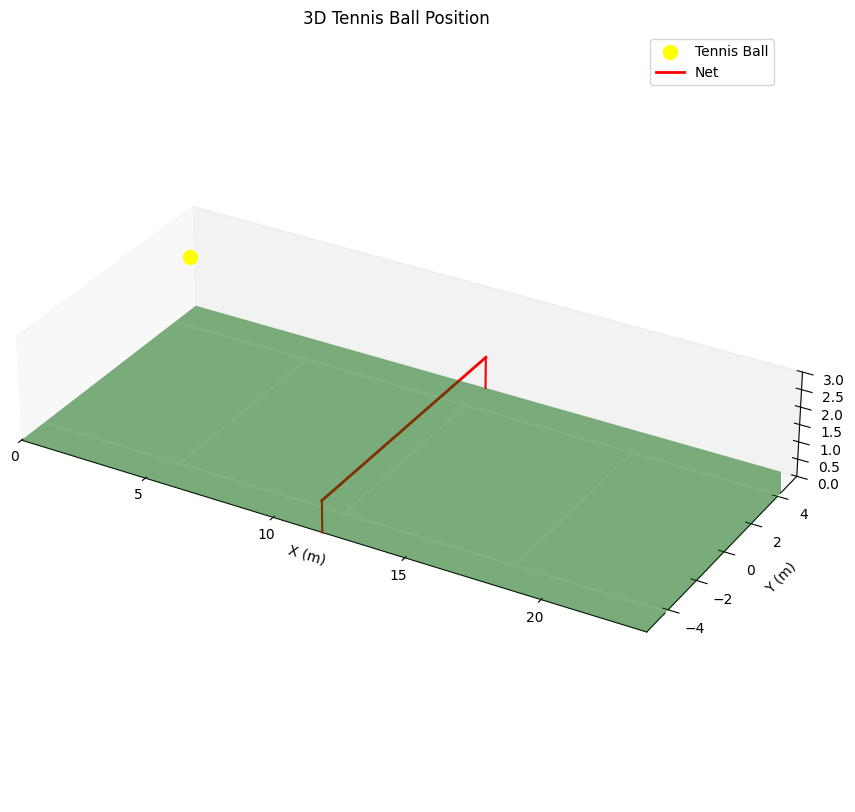

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Tennis court dimensions (in meters)
court_length = 23.77
doubles_width = 10.97
net_height = 0.914
service_box_length = 6.4
service_box_width = 4.115
tramline_width = 1.37

# Flatten and convert triangulated point to meters
ball_position = (points_3d.flatten()) / 1000.0

# Create figure
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot the tennis ball point
ax.scatter(
    ball_position[0], 
    ball_position[1], 
    ball_position[2], 
    marker="o", 
    color="yellow", 
    s=100,
    label="Tennis Ball"
)

# Court surface (X: length, Y: width)
x_court = np.array([0, court_length])
y_court = np.array([-doubles_width/2, doubles_width/2])
X, Y = np.meshgrid(x_court, y_court)
Z = np.zeros_like(X)
ax.plot_surface(X, Y, Z, color="green", alpha=0.5)

# Tramlines
ax.plot([0, court_length], [doubles_width/2 - tramline_width]*2, [0, 0], color="white", linewidth=2)
ax.plot([0, court_length], [-doubles_width/2 + tramline_width]*2, [0, 0], color="white", linewidth=2)

# Center line
center_x = court_length / 2
ax.plot(
    [center_x, center_x],
    [-service_box_width, service_box_width],
    [0, 0],
    color="white",
    linewidth=2
)

# Service box lines
ax.plot([center_x - service_box_length, center_x - service_box_length],
        [-service_box_width, service_box_width],
        [0, 0], color="white", linewidth=2)
ax.plot([center_x + service_box_length, center_x + service_box_length],
        [-service_box_width, service_box_width],
        [0, 0], color="white", linewidth=2)

# Net
ax.plot([center_x, center_x], [-doubles_width/2, doubles_width/2], [net_height, net_height], color="red", linewidth=2, label="Net")
for y in [-doubles_width/2, doubles_width/2]:
    ax.plot([center_x, center_x], [y, y], [0, net_height], color="red")

# Set plot limits
ax.set_xlim([0, court_length])
ax.set_ylim([-doubles_width/2, doubles_width/2])
ax.set_zlim([0, 3])
ax.set_box_aspect([court_length, doubles_width, 4])

# Labels
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("3D Tennis Ball Position")
ax.legend()
ax.grid(False)

plt.show()
